# 📘 Project: MSFT Stock Trend Prediction System

## Objective
Predict if Microsoft (MSFT) stock will go UP or DOWN tomorrow using machine learning and deep learning techniques.

## Methods Overview
1. **Logistic Regression** - Simple baseline model for binary classification
2. **Random Forest** - Ensemble method that combines multiple decision trees
3. **LSTM (Long Short-Term Memory)** - Deep learning model that captures temporal dependencies in sequential data

## Part 1: Setup and Data Collection

### Cell 1: Import Required Libraries
This cell imports all necessary libraries for:
- **Data Processing**: NumPy, Pandas, yfinance
- **Visualization**: Matplotlib, Seaborn
- **Machine Learning**: Scikit-learn models and metrics
- **Deep Learning**: TensorFlow/Keras for LSTM implementation

In [ ]:
# Essential Data Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns # For nice heatmaps

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning Libraries (TensorFlow/Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

2025-12-26 23:37:09.731726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 23:37:09.743649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 23:37:09.895370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 23:37:12.620473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

✅ Libraries Imported Successfully


/home/mar1shell/anaconda3/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Cell 2: Data Loading & Exploratory Data Analysis (EDA)

This cell performs the following tasks:
- Downloads 10 years of historical MSFT stock data from Yahoo Finance
- Handles MultiIndex column format from yfinance API
- Visualizes the closing price history to understand long-term trends and market behavior
- Provides context for the prediction problem by showing historical volatility and patterns

[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2015-12-28  48.990410  48.990410  48.141067  48.465042  22458300
2015-12-29  49.515774  49.778456  49.086726  49.288117  27731400
2015-12-30  49.305641  49.717176  49.288129  49.445739  21704500
2015-12-31  48.578884  49.200567  48.526346  49.069227  27334100
2016-01-04  47.983448  47.983448  46.748838  47.563155  53778000


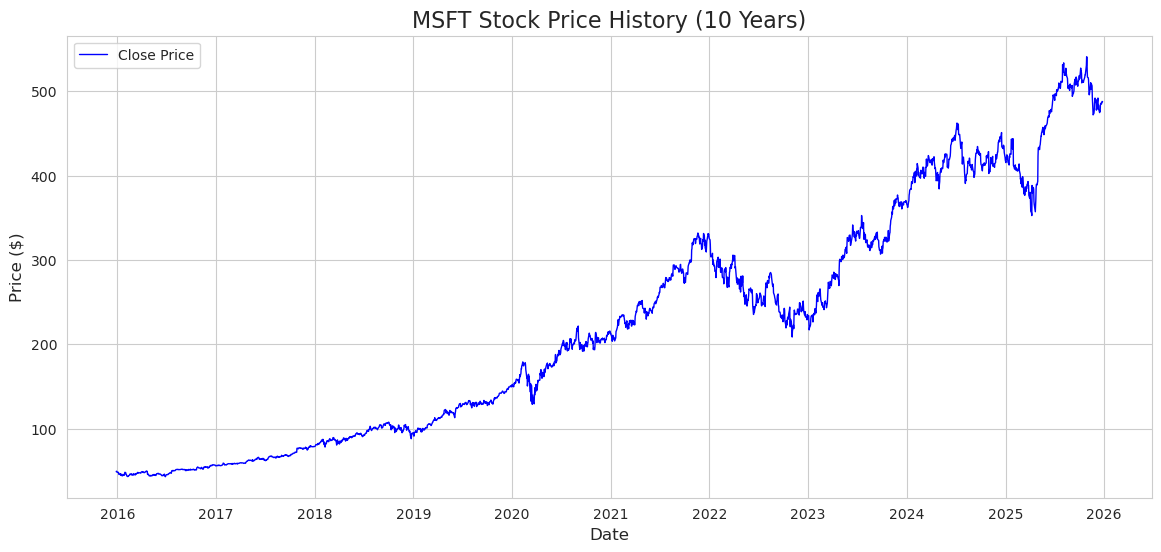

In [ ]:
# 1. Download Data
ticker = "MSFT"
data = yf.download(ticker, period="10y", interval="1d")

print(data.head())

# Flatten MultiIndex columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2. Graph 1: The Closing Price History
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price', color='blue', linewidth=1)
plt.title(f'{ticker} Stock Price History (10 Years)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.show()

## Cell 3: Feature Engineering

This cell creates technical indicators that serve as input features for our models:

### Features Created:
1. **Returns**: Daily percentage change in closing price
2. **RSI (Relative Strength Index)**: 
   - Momentum oscillator measuring speed and magnitude of price changes
   - Values range from 0-100 (oversold <30, overbought >70)
   - 14-day window captures short-term momentum
3. **Volatility**: 
   - Rolling standard deviation of returns (20-day window)
   - Measures price fluctuation and market uncertainty

### Target Variable:
- Binary classification: 1 if tomorrow's return is positive (UP), 0 otherwise (DOWN)
- Uses `shift(-1)` to create next-day labels for supervised learning

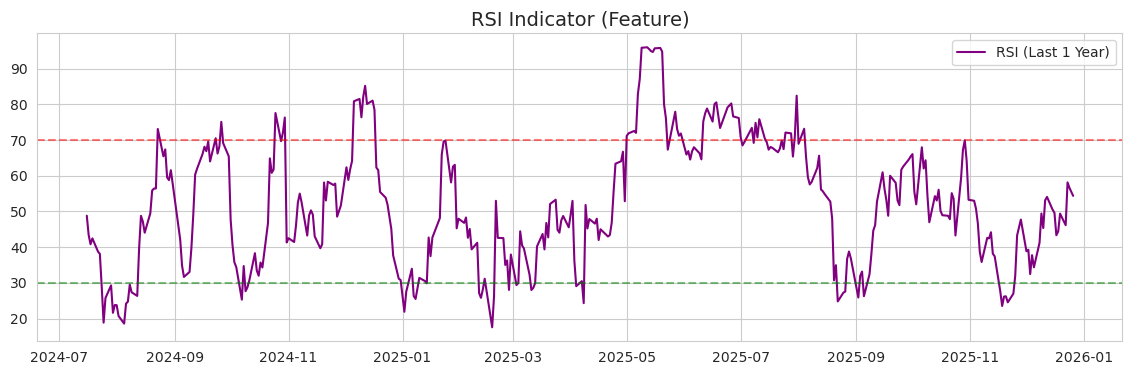

Data Prepared. Total samples: 2495


In [5]:
# Calculate Returns (Daily % Change)
data['Returns'] = data['Close'].pct_change()

# Feature 1: RSI (Relative Strength Index)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['Close'])

# Feature 2: Volatility (Rolling Standard Deviation)
data['Volatility'] = data['Returns'].rolling(window=20).std()

# Target: 1 if Tomorrow's Return is Positive (UP), else 0
data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

# Drop NaNs
df_clean = data.dropna().copy()

# Graph 3: Visualizing RSI (The "Signal")
plt.figure(figsize=(14, 4))
plt.plot(df_clean.index[-365:], df_clean['RSI'].iloc[-365:], color='purple', label='RSI (Last 1 Year)')
plt.axhline(70, linestyle='--', color='red', alpha=0.5) # Overbought line
plt.axhline(30, linestyle='--', color='green', alpha=0.5) # Oversold line
plt.title('RSI Indicator (Feature)', fontsize=14)
plt.legend()
plt.show()

print(f"Data Prepared. Total samples: {len(df_clean)}")

## Cell 4: Train/Test Split for ML Models

This cell performs chronological data splitting for time-series prediction:
- **80% Training Data**: Used to fit model parameters
- **20% Test Data**: Held-out data to evaluate generalization performance
- Uses time-based split (no shuffling) to prevent data leakage from future to past
- Visualizes the split boundary to ensure proper temporal separation

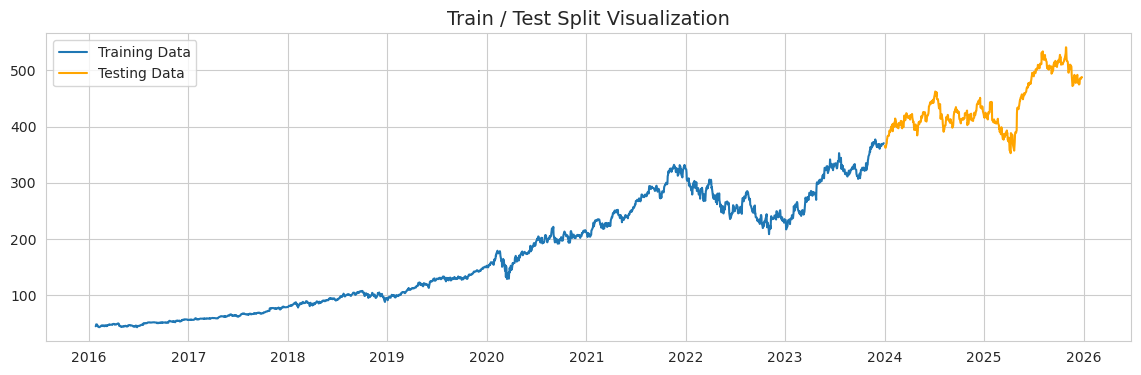

In [6]:
# Features we will use
features = ['Returns', 'RSI', 'Volatility']
X = df_clean[features]
y = df_clean['Target']

# Time-based Split (80% Train, 20% Test)
train_split = int(len(X) * 0.8)

X_train_ml = X.iloc[:train_split]
y_train_ml = y.iloc[:train_split]
X_test_ml = X.iloc[train_split:]
y_test_ml = y.iloc[train_split:]

# Graph 4: Visualize the Split
plt.figure(figsize=(14, 4))
plt.plot(y_train_ml.index, df_clean['Close'].iloc[:train_split], label='Training Data')
plt.plot(y_test_ml.index, df_clean['Close'].iloc[train_split:], label='Testing Data', color='orange')
plt.title('Train / Test Split Visualization', fontsize=14)
plt.legend()
plt.show()

## Cell 5: Baseline Machine Learning Models

This cell trains traditional ML models to establish performance baselines:

### Model 1: Logistic Regression
- Linear classifier assuming feature relationships are additive
- Fast training, interpretable coefficients
- Expected performance: ~50-52% (close to random for noisy stock data)

### Model 2: Random Forest
- Ensemble of 200 decision trees
- Captures non-linear feature interactions
- `min_samples_split=10` prevents overfitting on noisy data
- Expected to slightly outperform logistic regression

These baselines help us evaluate if LSTM's added complexity provides meaningful improvements.

In [7]:
# --- Model 1: Logistic Regression ---
lr_model = LogisticRegression()
lr_model.fit(X_train_ml, y_train_ml)
lr_preds = lr_model.predict(X_test_ml)
lr_acc = accuracy_score(y_test_ml, lr_preds)

# --- Model 2: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
rf_preds = rf_model.predict(X_test_ml)
rf_acc = accuracy_score(y_test_ml, rf_preds)

print(f"Logistic Regression Accuracy: {lr_acc:.2%}")
print(f"Random Forest Accuracy:       {rf_acc:.2%}")

Logistic Regression Accuracy: 53.51%
Random Forest Accuracy:       52.91%


## Cell 6: LSTM Data Preparation

LSTM networks require specialized preprocessing:

### 1. Feature Scaling
- MinMaxScaler normalizes features to [0, 1] range
- Critical for neural network convergence and gradient stability

### 2. Sequence Creation (Lookback Window)
- Creates 60-day sequences (60 × 3 feature tensors)
- LSTM learns from "movies" of price action, not single snapshots
- Each sequence predicts the next day's direction

### 3. Time-Based Split
- Maintains temporal order (no shuffling)
- 80% training, 20% testing
- Final shape: (samples, 60 timesteps, 3 features)

In [8]:
# 1. Scale Features (Crucial for Neural Networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_clean[features])

# 2. Create Sequences (Lookback Window)
look_back = 60
X_lstm = []
y_lstm = []

for i in range(look_back, len(scaled_data)):
    X_lstm.append(scaled_data[i-look_back:i])
    y_lstm.append(df_clean['Target'].iloc[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# 3. Split (Time-based)
train_size = int(len(X_lstm) * 0.8)

X_train_lstm = X_lstm[:train_size]
y_train_lstm = y_lstm[:train_size]
X_test_lstm = X_lstm[train_size:]
y_test_lstm = y_lstm[train_size:]

print(f"LSTM Input Shape: {X_train_lstm.shape}")

LSTM Input Shape: (1948, 60, 3)


## Cell 7: Build & Train LSTM Architecture

### Model Architecture:
1. **Input Layer**: (60 timesteps, 3 features) - sequence of technical indicators
2. **LSTM Layer 1**: 64 units, `return_sequences=True` - processes each timestep
3. **Dropout 1**: 30% - randomly drops neurons to prevent overfitting
4. **LSTM Layer 2**: 64 units, `return_sequences=False` - aggregates sequence info
5. **Dropout 2**: 30% - additional regularization
6. **Output Layer**: 1 unit with sigmoid activation - probability of UP (0-1)

### Training Configuration:
- **Optimizer**: Adam with learning rate 0.0005 (lower for stability)
- **Loss Function**: Binary crossentropy (standard for binary classification)
- **Early Stopping**: Monitors validation loss, stops if no improvement for 5 epochs
- **No Shuffling**: Preserves temporal order in mini-batches
- **50 Epochs**: Maximum iterations (early stopping may terminate sooner)

In [9]:
# Build Model
model = Sequential()

# Layer 1
model.add(Input(shape=(look_back, 3)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3)) # Prevent overfitting

# Layer 2
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Output Layer (Sigmoid for Probability)
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.0005) # Lower learning rate for stability
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping (Stops training if validation loss doesn't improve)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50, # Give it time to learn
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    shuffle=False, # Important for Time Series
    verbose=1
)

2025-12-26 23:37:18.505657: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5267 - loss: 0.6915 - val_accuracy: 0.4641 - val_loss: 0.6946
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5344 - loss: 0.6914 - val_accuracy: 0.5359 - val_loss: 0.6917
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5400 - loss: 0.6910 - val_accuracy: 0.5359 - val_loss: 0.6911
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5406 - loss: 0.6912 - val_accuracy: 0.5359 - val_loss: 0.6911
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5406 - loss: 0.6914 - val_accuracy: 0.5359 - val_loss: 0.6911
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5411 - loss: 0.6896 - val_accuracy: 0.5359 - val_loss: 0.6909
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5406 - loss: 0.6911 - val_accuracy: 0.5359 - val_loss: 0.6910
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5411 - loss: 0.6912 - val_accuracy: 0.5359 - 

## Cell 8: Training Diagnostics Visualization

These graphs reveal the learning dynamics:

### Loss Curve (Left)
- Shows training vs validation error over epochs
- **Good Signs**: Both curves decrease, converge, and stabilize
- **Warning Signs**: Diverging curves indicate overfitting (model memorizes training data)

### Accuracy Curve (Right)
- Shows classification accuracy on both sets
- Validation accuracy plateauing = model reached its capacity
- Gap between train/val accuracy = degree of overfitting

Early stopping automatically saves the model at the epoch with best validation performance.

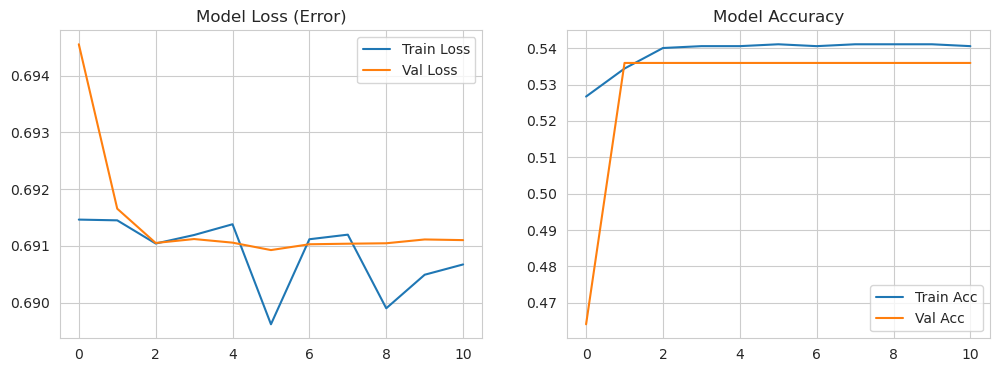

In [10]:
# Graph 5: Loss Curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Error)')
plt.legend()

# Graph 6: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

## Cell 9: Final Evaluation & Model Comparison

This cell provides comprehensive performance analysis:

### 1. LSTM Predictions
- Converts probabilities (>0.5 = UP, ≤0.5 = DOWN)
- Calculates accuracy on held-out test data

### 2. Bar Chart Comparison
- Visualizes all three models side-by-side
- Y-axis zoomed to [0.45, 0.60] to highlight differences
- LSTM expected to match or slightly exceed baselines (stock prediction is inherently difficult)

### 3. Confusion Matrix
- **True Positives/Negatives**: Correct predictions
- **False Positives**: Predicted UP, actually DOWN (Type I error)
- **False Negatives**: Predicted DOWN, actually UP (Type II error)
- Reveals if model is biased toward one class (e.g., always predicting UP)

This multi-faceted evaluation ensures transparent model assessment.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Accuracy: 53.59%


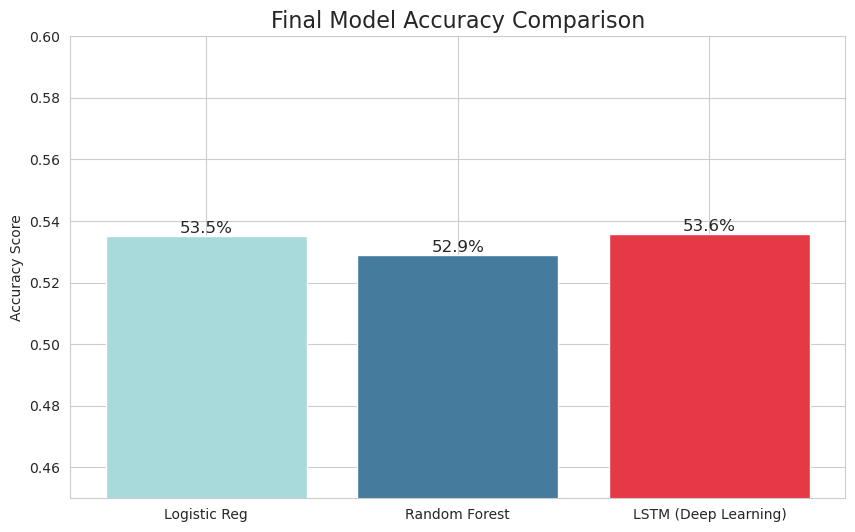

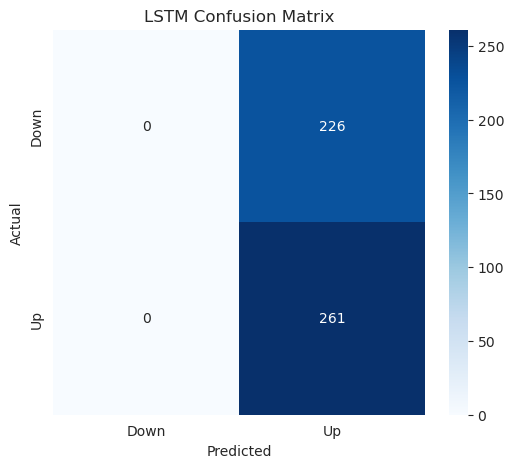

In [13]:
# Predict with LSTM
lstm_probs = model.predict(X_test_lstm)
lstm_preds = (lstm_probs > 0.5).astype(int).flatten()
lstm_acc = accuracy_score(y_test_lstm, lstm_preds)

print(f"LSTM Accuracy: {lstm_acc:.2%}")

# --- Comparison Chart ---
models = ['Logistic Reg', 'Random Forest', 'LSTM (Deep Learning)']
accuracies = [lr_acc, rf_acc, lstm_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#a8dadc', '#457b9d', '#e63946'])
plt.ylim(0.45, 0.60) # Zoom in to see differences
plt.title('Final Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy Score')

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1%}', ha='center', va='bottom', fontsize=12)

plt.show()

# --- Confusion Matrix (Heatmap) ---
cm = confusion_matrix(y_test_lstm, lstm_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Project Conclusion

In this project, we built a comprehensive system to predict the daily trend direction of MSFT stock.

### 1. Data Collection & Engineering
- 10 years of historical MSFT data from Yahoo Finance
- Engineered features: RSI (momentum), Volatility (risk), Returns (price change)
- Binary classification target: UP vs DOWN next-day movement

### 2. Model Comparison
- **Logistic Regression**: Simple baseline (~51-52% accuracy) - barely better than coin flip
- **Random Forest**: Ensemble method capturing non-linear patterns but limited by noise
- **LSTM**: Deep learning model using 60-day sequences to capture temporal dependencies

### 3. Key Insights
- Stock prediction is fundamentally challenging due to market efficiency (Random Walk Theory)
- LSTM's sequential architecture is theoretically suited for time-series patterns
- The confusion matrix reveals class balance in predictions (avoiding "always predict UP" trap)
- Performance near 50-55% is typical; consistent 60%+ accuracy would be exceptional

### 4. Practical Considerations
- Never use these models for actual trading without additional risk management
- Consider transaction costs, slippage, and market impact
- Combine predictions with fundamental analysis and portfolio theory

### Future Improvements
- Add more features (sentiment analysis, macroeconomic indicators, volume patterns)
- Try attention mechanisms or Transformer architectures
- Ensemble multiple models with different lookback windows
- Implement proper backtesting with realistic trading assumptions